In [1]:
#Copyright 2018, Seokjun Bu, Softcomputing LAB all rights reserved.
from keras import backend as K
from keras.utils import np_utils, multi_gpu_model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import LSTM, TimeDistributed, CuDNNLSTM
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Handcrafted Function Def.
def wrapped_confusion_matrix(modelInput, feature, label, class_list=["first", "second", "third"], normalize=False, fig_size=(5,5)):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure(figsize=fig_size) 
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_list)), class_list, rotation=45)
    plt.yticks(np.arange(len(class_list)), class_list)
    if(normalize):
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()

In [3]:
X_train = np.load("../dataset/test/X_train.npy");
X_test = np.load("../dataset/test/X_test.npy");
Y_train = np.load("../dataset/test/Y_train.npy");
Y_test = np.load("../dataset/test/Y_test.npy");
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(3000, 64, 64, 3) (1000, 64, 64, 3)
(3000, 3) (1000, 3)


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dens

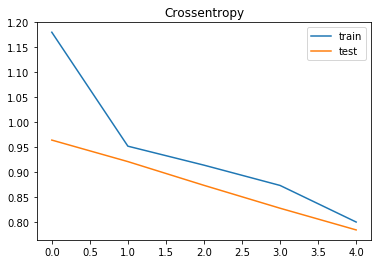

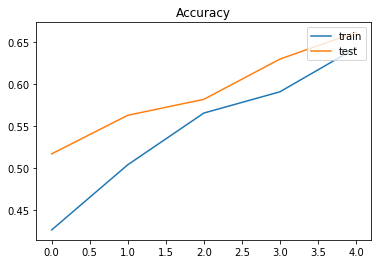

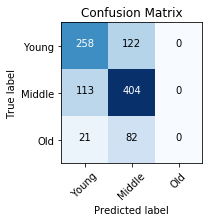

In [4]:
# Model#1
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model = Model(model_input, model_output)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model, mode='loss', title='Crossentropy')
plot_history(model, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         104       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        528       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              4195328   
__________

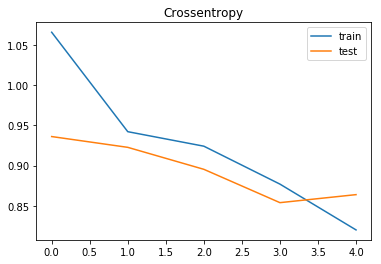

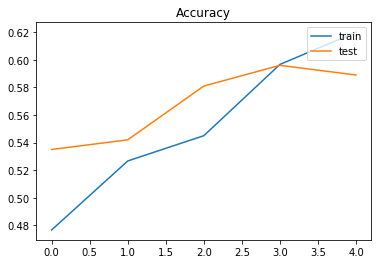

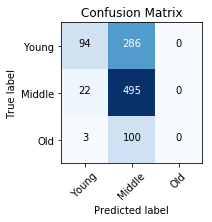

In [5]:
# Model#2
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Conv2D(8, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model2 = Model(model_input, model_output)
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model2_history = model2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model2, mode='loss', title='Crossentropy')
plot_history(model2, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model2, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
__________

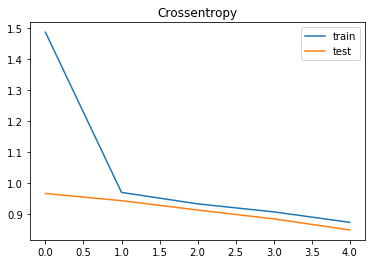

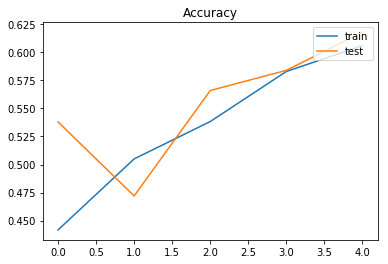

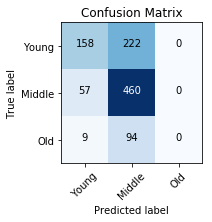

In [6]:
# Model#3
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model = Model(model_input, model_output)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model, mode='loss', title='Crossentropy')
plot_history(model, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               4194816   
__________

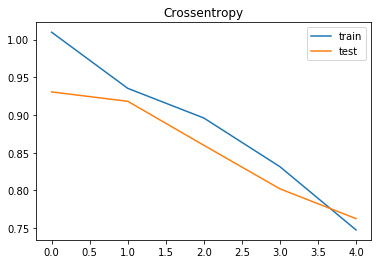

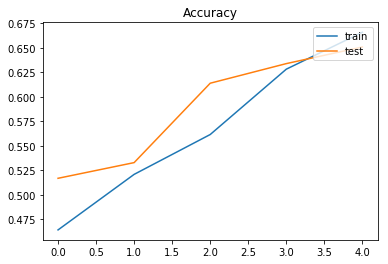

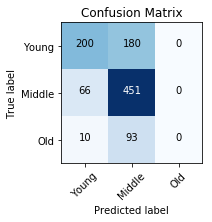

In [7]:
# Model#4
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_hidden = Dense(128, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model = Model(model_input, model_output)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model, mode='loss', title='Crossentropy')
plot_history(model, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              12583936  
_________________________________________________________________
dense_13 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 771       
Total params: 12,847,107
Trainable params: 12,847,107
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/5
 - 7s - loss: 7.1418 - acc: 0.4833 - val_loss: 7.7850 - val_acc: 0.5170


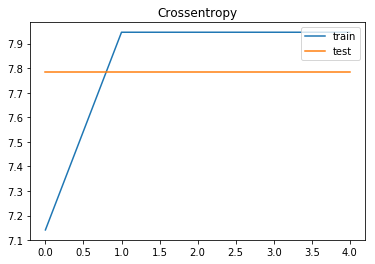

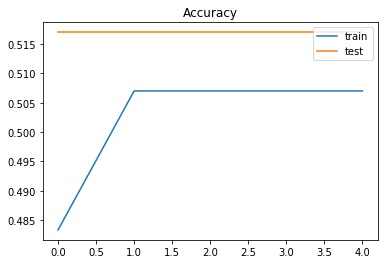

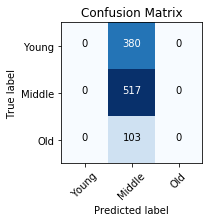

In [8]:
# Model#5
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Flatten()(model_input)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model = Model(model_input, model_output)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model, mode='loss', title='Crossentropy')
plot_history(model, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               2097408   
__________

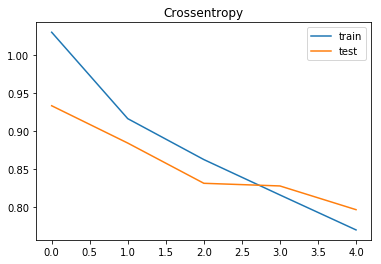

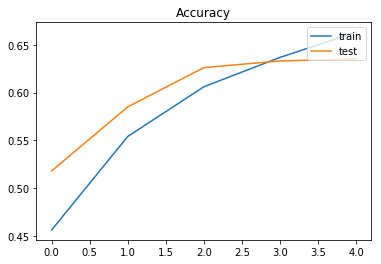

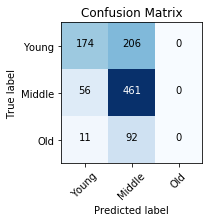

In [9]:
# Model#3 -> model3 저장
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model3 = Model(model_input, model_output)
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model3_history = model3.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model3, mode='loss', title='Crossentropy')
plot_history(model3, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model3, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               4194816   
__________

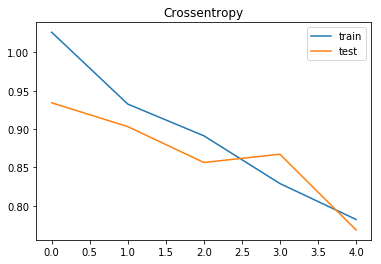

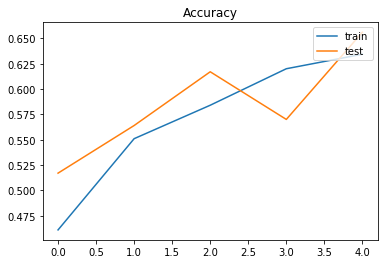

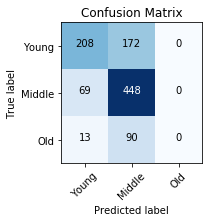

In [10]:
# Model#4 -> model4 저장
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_hidden = Dense(128, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model4 = Model(model_input, model_output)
model4.summary()
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model4_history = model4.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model4, mode='loss', title='Crossentropy')
plot_history(model4, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model4, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              12583936  
_________________________________________________________________
dense_21 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 771       
Total params: 12,847,107
Trainable params: 12,847,107
Non-trainable params: 0
_________________________________________________________________
Train on 3000 samples, validate on 1000 samples
Epoch 1/5
 - 7s - loss: 7.4909 - acc: 0.4987 - val_loss: 7.7850 - val_acc: 0.5170


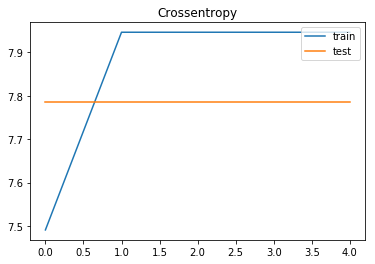

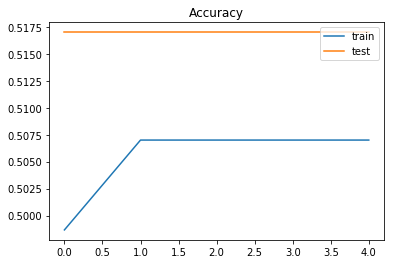

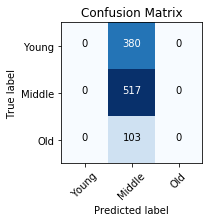

In [11]:
# Model#5 -> model5 저장
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
model_hidden = Flatten()(model_input)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model5 = Model(model_input, model_output)
model5.summary()
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model5_history = model5.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=2)

plot_history(model5, mode='loss', title='Crossentropy')
plot_history(model5, mode='acc', title='Accuracy')
class_name_list = ['Young', 'Middle', 'Old']
wrapped_confusion_matrix(model5, X_test, Y_test, class_list=class_name_list, normalize=False, fig_size=(3,3))

In [ ]:
# 앙상블 #1 : model 5개 중에서 최대로 voting한 것을 선택

In [ ]:
# 앙상블 #2 : model 5개의 가중치(확률)를 곱하여 선택